Here I try to solve a Empirical Bayes Poisson Mean problem using VAE (detail described in https://www.overleaf.com/project/5bd084d90a33772e7a7f99a2  `EBVAE.tex`). 

The model is the simplest one. For now I take only one sample ($L = 1$) from $q_{\phi}$ for both training and computing posterior mean. 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import numpy as np
from matplotlib import pyplot as plt

import pdb

In [2]:
class Map(dict):
    """
    Example:
    m = Map({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])
    """
    def __init__(self, *args, **kwargs):
        super(Map, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.items():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.items():
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(Map, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(Map, self).__delitem__(key)
        del self.__dict__[key]

In [3]:
def sample_trunc_normal(mu, sd = 1):
    x = np.random.normal(loc = mu, scale = sd, size = 1).item()
    if x > 0:
        return x
    else:
        return 0
    
def sample_poisson_trunc_normal(n, mu, sd, seed = 123):
    np.random.seed(seed)
    lam = [sample_trunc_normal(mu, sd) for i in range(n)]
    print(len(lam))
    x = np.random.poisson(lam = lam)
    return {"lam":lam, "x":x}

* Simulate data: $\lambda$s are from truncated normal; †hen $x \sim Pois(\lambda)$. I plot the histogram of data below. 
* Model: specified in the `args` class. 

5000


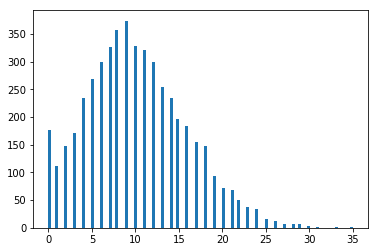

In [4]:
## simulate data
n = 5000
mu = 10
sd = 5
sim = sample_poisson_trunc_normal(n, mu,sd, seed = 123)
plt.hist(sim["x"], bins=100)
plt.show()

## model arguments
args = Map(batch_size = n, epochs = 2000, no_cuda = 1, seed = 123, log_interval= 100, L = 20)
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

data = torch.Tensor(sim["x"].reshape(-1,1))
train_loader = torch.utils.data.DataLoader(data, 
                                           batch_size=args.batch_size, shuffle=False, **kwargs)


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        mid_len = 10
        self.fc1 = nn.Linear(1, mid_len)
        self.fc21 = nn.Linear(mid_len, 1)
        self.fc22 = nn.Linear(mid_len, 1)
        self.fc3 = nn.Linear(1, 1)


    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    
    def reparameterize(self, mu, logvar, L = None):
        if L is None: ## L is the number of samples we take to compute E_q ...
            L = args.L
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std.unsqueeze(-1).expand(-1,L, -1)) ## [batch_size, args.L, 1]
        return mu.unsqueeze(-1) + eps*std.unsqueeze(-1) ## [batch_size, args.L, 1]

    def decode(self, z):
        h3 = self.fc3(z).clamp(min = 1e-5)
        return h3 ## [batch_size, args.L, 1]

    def forward(self, x, L = None):
        mu, logvar = self.encode(x.view(-1, 1)) ## mu, logvar: [batch_size, 1]
        z = self.reparameterize(mu, logvar, L) ## z: [batch_size, args.L, 1]
        theta = self.decode(z) ## theta: [batch_size, args.L, 1]
        return theta, mu, logvar
    
        
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Expected (under q) Poisson loss + KL divergence losses summed over all elements and batch
def loss_function(theta, x, mu, logvar):    
    poisson_ll = (- theta + x.view(-1,1,1) * torch.log(theta)).sum()/args.L
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    neg_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return - poisson_ll + neg_KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        theta_batch, mu, logvar = model.forward(data)
        loss = loss_function(theta_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

    if epoch % args.log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))
    
    return data


if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        data = train(epoch)

====> Epoch: 100 Average loss: -0.0074
====> Epoch: 200 Average loss: -1.7422
====> Epoch: 300 Average loss: -3.0664
====> Epoch: 400 Average loss: -4.1313
====> Epoch: 500 Average loss: -5.0407
====> Epoch: 600 Average loss: -5.8208
====> Epoch: 700 Average loss: -6.5061
====> Epoch: 800 Average loss: -7.1215
====> Epoch: 900 Average loss: -7.6715
====> Epoch: 1000 Average loss: -8.1662
====> Epoch: 1100 Average loss: -8.6066
====> Epoch: 1200 Average loss: -9.0147
====> Epoch: 1300 Average loss: -9.3788
====> Epoch: 1400 Average loss: -9.7135
====> Epoch: 1500 Average loss: -10.0247
====> Epoch: 1600 Average loss: -10.3033
====> Epoch: 1700 Average loss: -10.5735
====> Epoch: 1800 Average loss: -10.8007
====> Epoch: 1900 Average loss: -11.0270
====> Epoch: 2000 Average loss: -11.2276


The avergae loss goes down from $2$ to $-11$ in 2000 iterations. 

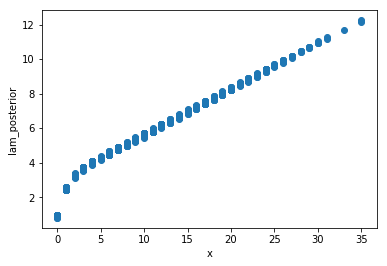

In [6]:
lam, mu, logvar = model.forward(data, L = 1000)
plt.scatter(sim["x"], lam.mean(dim = 1)[:,0].tolist())
plt.xlabel("x")
plt.ylabel("lam_posterior")
plt.show()

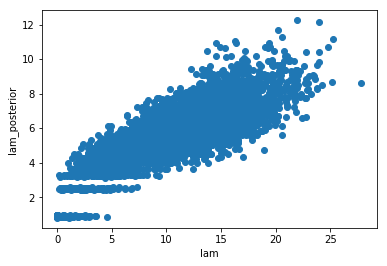

In [7]:
plt.scatter(sim["lam"], lam.mean(dim = 1)[:,0].tolist())
plt.xlabel("lam")
plt.ylabel("lam_posterior")
plt.show()

In [8]:
import pickle
out = {"x":sim["x"], "lam":np.array(sim["lam"]), "posterior_vae":np.array(lam.mean(dim = 1)[:,0].tolist())}
with open("../data/poisson-normal.pkl", "wb") as f:
    pickle.dump(out, f)